## Step 1: Load the MFCC + Delta Dataset

We load a balanced dataset of 100 orca call clips and 100 non-orca clips (from file 61062.wav), each with 26 MFCC-based features and metadata.


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("mfcc_balanced_100x100.csv")

# Show size and sample
print(f"Loaded {len(df)} clips")
df.head()


Loaded 2000 clips


,clip_name,label,source_wav,start_time,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,delta_mfcc_4,delta_mfcc_5,delta_mfcc_6,delta_mfcc_7,delta_mfcc_8,delta_mfcc_9,delta_mfcc_10,delta_mfcc_11,delta_mfcc_12,delta_mfcc_13
0,clip_00001_rpi-bush-point_2020_09_27_23_17_00_...,orca_call,rpi-bush-point_2020_09_27_23_17_00.wav,13.728845,-298.720042,119.153468,-72.291055,20.357000,-31.211637,51.208784,...,0.095042,0.045561,0.095926,-0.037923,-0.070886,-0.030071,0.026496,-0.094586,-0.057488,0.040063
1,clip_00002_92301005_0_00.wav,orca_call,92301005.wav,0.000000,-420.171153,87.696830,-12.883369,-5.147138,10.693891,3.252740,...,-0.132884,-0.031189,0.003881,-0.068561,-0.098607,0.034963,-0.034743,-0.070847,-0.095932,0.081832
2,clip_00003_60026_410_87.wav,orca_call,60026.wav,410.865000,-419.237033,201.325396,79.880303,35.400281,35.496885,25.458583,...,-0.173578,-0.057253,-0.039641,0.008600,0.061710,0.048176,0.005591,-0.010428,0.007826,0.026172
3,clip_00004_9230402K_0_00.wav,orca_call,9230402K.wav,0.000000,-503.046124,75.614411,-20.939762,3.345041,4.188498,0.289673,...,-0.039522,-0.018576,-0.056716,0.009147,-0.005176,-0.071448,0.017064,-0.000700,0.069856,0.036954
4,clip_00005_9230001Y_0_00.wav,orca_call,9230001Y.wav,0.000000,-426.975692,118.904999,-38.131110,-14.012378,2.558288,-18.259132,...,0.155997,0.079069,-0.095678,0.348783,0.423699,0.095687,-0.039517,-0.173172,-0.276185,-0.282590


## Step 2: Prepare Features and Labels

We extract the 13 MFCC and 13 delta MFCC features as model inputs (`X`) and convert the `label` column to binary values for classification (`y`).


In [2]:
# Extract feature columns (everything starting with 'mfcc' or 'delta_mfcc')
feature_cols = [col for col in df.columns if col.startswith("mfcc") or col.startswith("delta_mfcc")]

X = df[feature_cols]
y = df["label"].map({"no_call": 0, "orca_call": 1})  # convert to numeric

print(f"X shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")


X shape: (2000, 26)
y distribution:
label
1    1000
0    1000
Name: count, dtype: int64


## Step 3: Train/Test Split and Standardization

We split the dataset into training and testing sets, and standardize the feature values to have zero mean and unit variance. This prepares the data for model training.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and test sets (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Feature scaling complete
Train size: 1600, Test size: 400


## Step 4: Train Logistic Regression Model

We train a logistic regression model using the standardized MFCC and delta features. Then we evaluate the model’s precision, recall, and overall accuracy on the test set.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate
print("✅ Logistic Regression Results")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["no_call", "orca_call"]))


✅ Logistic Regression Results
Confusion Matrix:
[[156  44]
 [ 23 177]]

Classification Report:
              precision    recall  f1-score   support

     no_call       0.87      0.78      0.82       200
   orca_call       0.80      0.89      0.84       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



## Step 5a: Confusion Matrix Heatmap

We visualize the model’s prediction results to see how often it correctly identifies orca and no_call clips.


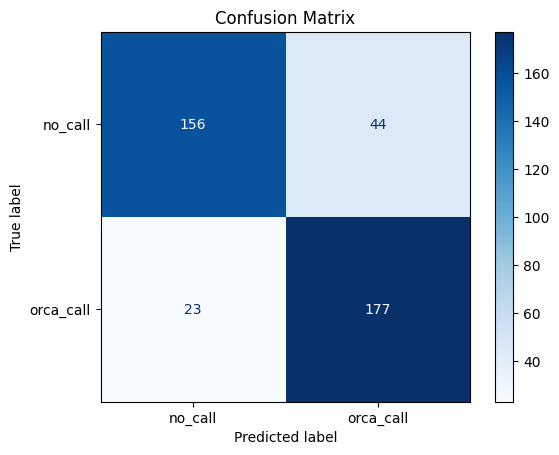

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test_scaled, y_test,
    display_labels=["no_call", "orca_call"],
    cmap="Blues",
    values_format="d"
)

plt.title("Confusion Matrix")
plt.show()


## Step 5b: Logistic Regression Feature Weights

We plot the model’s learned coefficients to understand which MFCC and delta MFCC features most influence the prediction.


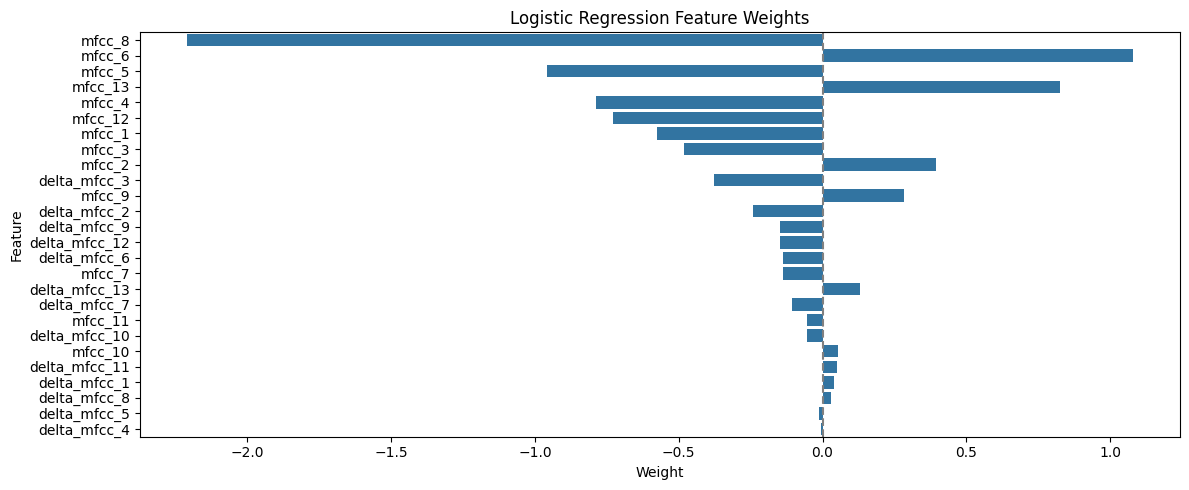

In [6]:
# Get feature names and weights
import numpy as np

coefficients = model.coef_[0]
feature_names = X.columns  # same order as X_train

# Sort by absolute importance
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

plt.figure(figsize=(12, 5))
sns.barplot(x=coefficients[sorted_indices], y=feature_names[sorted_indices])
plt.title("Logistic Regression Feature Weights")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## Step 6: Train Random Forest Classifier

We train a Random Forest model on the same MFCC and delta features, and compare its performance to the logistic regression baseline.


In [7]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
print("Random Forest Results")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["no_call", "orca_call"]))


Random Forest Results
Confusion Matrix:
[[191   9]
 [  5 195]]

Classification Report:
              precision    recall  f1-score   support

     no_call       0.97      0.95      0.96       200
   orca_call       0.96      0.97      0.97       200

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400



In [19]:
import soundfile as sf
import librosa
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


def resample_with_progress(data, orig_sr, target_sr=22050, chunk_duration_sec=60):
    chunk_samples = int(orig_sr * chunk_duration_sec)
    total_samples = len(data)
    chunks = int(np.ceil(total_samples / chunk_samples))
    
    print(f"Total duration: {total_samples / orig_sr:.1f}s | Resampling in {chunks} chunks...")

    resampled_chunks = []
    for i in range(chunks):
        start = i * chunk_samples
        end = min(start + chunk_samples, total_samples)
        chunk = data[start:end]

        print(f"→ Resampling chunk {i+1}/{chunks} ({(end - start)/orig_sr:.1f}s)...", end=" ")
        resampled_chunk = librosa.resample(chunk.astype(np.float32), orig_sr=orig_sr, target_sr=target_sr)
        resampled_chunks.append(resampled_chunk)
        print("done.")

    return np.concatenate(resampled_chunks)


def scan_wav_for_orca_calls(
    wav_path,
    model,
    scaler,
    window_size=2.0,
    step_size=0.5,
    n_mfcc=13
):
    print(f"Scanning: {wav_path}")
    data, sr = librosa.load(wav_path, sr=22050, mono=True)
    print(f"Loaded. Duration: {len(data)/sr:.1f}s at {sr}Hz")

    current_time = 0.0
    detections = []
    last_detection = -float("inf")


    while current_time + window_size <= len(data) / sr:
        start_sample = int(current_time * sr)
        end_sample = int((current_time + window_size) * sr)
        clip = data[start_sample:end_sample]

        mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        features = np.concatenate([np.mean(mfcc, axis=1), np.mean(delta, axis=1)]).reshape(1, -1)

        features_scaled = scaler.transform(features)
        proba = model.predict_proba(features_scaled)[0]
        orca_index = list(model.classes_).index(1)
        confidence = proba[orca_index]
        
        if confidence > 0.95 and current_time - last_detection >= 3.0:
            def format_time(seconds):
                m = int(seconds // 60)
                s = int(seconds % 60)
                return f"{m:02d}:{s:02d}"
            
            start_fmt = format_time(current_time)
            end_fmt = format_time(current_time + window_size)
            
            print(f"🐋 Detected orca call: {start_fmt} → {end_fmt} | Confidence: {confidence:.2f}")

            detections.append((current_time, current_time + window_size))
            last_detection = current_time

        current_time += step_size

    if not detections:
        print("No calls detected.")
    return detections



In [20]:
print("Running sim")
detections = scan_wav_for_orca_calls(
    wav_path="data/wav/live_feed_sim.wav",  # or whichever unseen file you want
    model=rf_model,
    scaler=scaler
)


Running sim
Scanning: data/wav/live_feed_sim.wav
Loaded. Duration: 2784.7s at 22050Hz
🐋 Detected orca call: 09:38 → 09:40 | Confidence: 0.97
🐋 Detected orca call: 09:47 → 09:49 | Confidence: 0.98
🐋 Detected orca call: 09:50 → 09:52 | Confidence: 0.98
🐋 Detected orca call: 09:53 → 09:55 | Confidence: 0.98
🐋 Detected orca call: 09:58 → 10:00 | Confidence: 0.97
🐋 Detected orca call: 10:01 → 10:03 | Confidence: 0.96
🐋 Detected orca call: 10:06 → 10:08 | Confidence: 0.96
🐋 Detected orca call: 10:09 → 10:11 | Confidence: 0.99
🐋 Detected orca call: 10:12 → 10:14 | Confidence: 0.98
🐋 Detected orca call: 10:15 → 10:17 | Confidence: 0.98
🐋 Detected orca call: 10:22 → 10:24 | Confidence: 0.96
🐋 Detected orca call: 10:26 → 10:28 | Confidence: 0.96
🐋 Detected orca call: 10:29 → 10:31 | Confidence: 0.99
🐋 Detected orca call: 10:32 → 10:34 | Confidence: 0.97
🐋 Detected orca call: 10:35 → 10:37 | Confidence: 0.98
🐋 Detected orca call: 10:38 → 10:40 | Confidence: 0.98
🐋 Detected orca call: 10:41 → 10:4